# Lab-6 : Decision Tree
- [Understanding decision tree structures](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py)


## 1. Understanding Decision Tree Structures
The decision tree structure can be analysed to gain further insight on the relation between the features and the target to predict. How to retriev 
- Binary Tree structures
- Depth of each node and whether or not it's a leaf
- Nodes that were reached by a sample using decision_path method
- Leaf that was reached by a sample using the apply method
- The rule that were used to predict a sample
- Decision path shared by a group of samples


In [1]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn import tree
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [2]:
# How to train a tree classifier ?
""" 
1. Load the dataset
2. split the data into training and testing through preprocessing.
3. Load the model architecture and pass train it using the fit method by passing 
data as features and target.
"""
iris = load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

clf = DecisionTreeClassifier(max_leaf_nodes=3, random_state=0)
clf.fit(X_train, y_train)


DecisionTreeClassifier(max_leaf_nodes=3, random_state=0)

The decision classifier has an attribute called tree_ which allows access to low level attributes such as node_count, the total number of nodes, and max_depth, the maximal depth of the tree. The tree_.compute_node_depths() method computes the depth of each node in the tree. tree_ also stores the entire binary tree structure, represented as a number of parallel arrays. The i-th element of each array holds information about the node i. Node 0 is the tree’s root. Some of the arrays only apply to either leaves or split nodes. In this case the values of the nodes of the other type is arbitrary. For example, the arrays feature and threshold only apply to split nodes. The values for leaf nodes in these arrays are therefore arbitrary.

In [3]:
# 1. Total number of nodes in the decision tree 
nodes = clf.tree_.node_count
print(nodes)
# 2. 
child_left = clf.tree_.children_left
child_right = clf.tree_.children_right
print(child_right)
print(child_right)
# 3. features
feature = clf.tree_.feature
nfeature = clf.tree_.n_features
print(feature)
# 4. 
thres = clf.tree_.threshold
print(thres)
# 5. 
""" 
The tree_.value array is a 3D array of shape [n_nodes, n_classes, n_outputs] which provides 
the count of samples reaching a node for each class and for each output. Each node has a value array which is the number of weighted samples reaching this node for each output and class.
"""
values = clf.tree_.value
print(values)

""" 
Lets take an example : tree built on the iris dataset, the root node has value = [37, 34, 41], indicating there are 37 samples of class 0, 34 samples of class 1, and 41 samples of class 2 at the root node. 
Traversing the tree, the samples are split and as a result, the value array reaching each node changes. The left child of the root node has value = [37, 0, 0] because all 37 samples in the left child node are from class 0.
"""


5
[ 2 -1  4 -1 -1]
[ 2 -1  4 -1 -1]
[ 3 -2  2 -2 -2]
[ 0.80000001 -2.          4.95000005 -2.         -2.        ]
[[[37. 34. 41.]]

 [[37.  0.  0.]]

 [[ 0. 34. 41.]]

 [[ 0. 33.  3.]]

 [[ 0.  1. 38.]]]


In [4]:
# Compute the depth of the each nodes whether it is a leaf node or not ?
node_depth = np.zeros(shape=nodes, dtype=np.int64)
is_leaves = np.zeros(shape=nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = child_left[node_id] != child_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((child_left[node_id], depth + 1))
        stack.append((child_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

print(
    "The binary tree structure has {n} nodes and has "
    "the following tree structure:\n".format(n=nodes)
)
for i in range(nodes):
    if is_leaves[i]:
        print(
            "{space}node={node} is a leaf node with value={value}.".format(
                space=node_depth[i] * "\t", node=i, value=values[i]
            )
        )
    else:
        print(
            "{space}node={node} is a split node with value={value}: "
            "go to node {left} if X[:, {feature}] <= {threshold} "
            "else to node {right}.".format(
                space=node_depth[i] * "\t",
                node=i,
                left=child_left[i],
                feature=feature[i],
                threshold=thres[i],
                right=child_right[i],
                value=values[i],
            )
        )

The binary tree structure has 5 nodes and has the following tree structure:

node=0 is a split node with value=[[37. 34. 41.]]: go to node 1 if X[:, 3] <= 0.800000011920929 else to node 2.
	node=1 is a leaf node with value=[[37.  0.  0.]].
	node=2 is a split node with value=[[ 0. 34. 41.]]: go to node 3 if X[:, 2] <= 4.950000047683716 else to node 4.
		node=3 is a leaf node with value=[[ 0. 33.  3.]].
		node=4 is a leaf node with value=[[ 0.  1. 38.]].


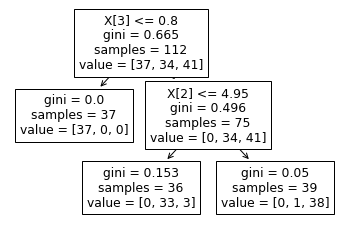

In [5]:
tree.plot_tree(clf)
plt.show()

### Decision Path
We will also retrieve the decision path of samples of interest. The decision_path method outputs an indicator matrix that allows us to retrieve the nodes the samples of interest traverse through. A non zero element in the indicator matrix at position (i, j) indicates that the sample i goes through the node j. Or, for one sample i, the positions of the non zero elements in row i of the indicator matrix designate the ids of the nodes that sample goes through.

The leaf ids reached by samples of interest can be obtained with the apply method. This returns an array of the node ids of the leaves reached by each sample of interest. Using the leaf ids and the decision_path we can obtain the splitting conditions that were used to predict a sample or a group of samples. First, let’s do it for one sample. Note that node_index is a sparse matrix.

In [6]:
node_indicator = clf.decision_path(X_test)
leaf_id = clf.apply(X_test)

sample_id = 0
# obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
node_index = node_indicator.indices[
    node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
]

print("Rules used to predict sample {id}:\n".format(id=sample_id))
for node_id in node_index:
    # continue to the next node if it is a leaf node
    if leaf_id[sample_id] == node_id:
        continue

    # check if value of the split feature for sample 0 is below threshold
    if X_test[sample_id, feature[node_id]] <= thres[node_id]:
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print(
        "decision node {node} : (X_test[{sample}, {feature}] = {value}) "
        "{inequality} {threshold})".format(
            node=node_id,
            sample=sample_id,
            feature=feature[node_id],
            value=X_test[sample_id, feature[node_id]],
            inequality=threshold_sign,
            threshold=thres[node_id],
        )
    )

Rules used to predict sample 0:

decision node 0 : (X_test[0, 3] = 2.4) > 0.800000011920929)
decision node 2 : (X_test[0, 2] = 5.1) > 4.950000047683716)


In [7]:
# If we have a group of samples then we can determine the common nodes the samples go through
sample_ids = [0, 1]
# boolean array indicating the nodes both samples go through
common_nodes = node_indicator.toarray()[sample_ids].sum(axis=0) == len(sample_ids)
# obtain node ids using position in array
common_node_id = np.arange(nodes)[common_nodes]

print(
    "\nThe following samples {samples} share the node(s) {nodes} in the tree.".format(
        samples=sample_ids, nodes=common_node_id
    )
)
print("This is {prop}% of all nodes.".format(prop=100 * len(common_node_id) / nodes))


The following samples [0, 1] share the node(s) [0 2] in the tree.
This is 40.0% of all nodes.


## 2. Visualize the decision surface of the decision tree

[Plot the decision surface of decision trees trained on the iris dataset](https://scikit-learn.org/stable/auto_examples/tree/plot_iris_dtc.html#sphx-glr-auto-examples-tree-plot-iris-dtc-py)

For each pair of iris features, the decision tree learns decision boundaries made of combinations of simple thresholding rules inferred from the training samples.

Show that tree structure of a model build on all of the features ?

In [12]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_iris
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier

ImportError: cannot import name 'DecisionBoundaryDisplay' from 'sklearn.inspection' (c:\Users\sony.gosala\.conda\envs\mne\lib\site-packages\sklearn\inspection\__init__.py)

In [ ]:

# Parameters
n_classes = 3
plot_colors = "ryb"
plot_step = 0.02


for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]):
    # We only take the two corresponding features
    X = iris.data[:, pair]
    y = iris.target

    # Train
    clf = DecisionTreeClassifier().fit(X, y)

    # Plot the decision boundary
    ax = plt.subplot(2, 3, pairidx + 1)
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
    DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        cmap=plt.cm.RdYlBu,
        response_method="predict",
        ax=ax,
        xlabel=iris.feature_names[pair[0]],
        ylabel=iris.feature_names[pair[1]],
    )

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(
            X[idx, 0],
            X[idx, 1],
            c=color,
            label=iris.target_names[i],
            cmap=plt.cm.RdYlBu,
            edgecolor="black",
            s=15,
        )

plt.suptitle("Decision surface of decision trees trained on pairs of features")
plt.legend(loc="lower right", borderpad=0, handletextpad=0)
_ = plt.axis("tight")


In [ ]:
from sklearn.tree import plot_tree

plt.figure()
clf = DecisionTreeClassifier().fit(iris.data, iris.target)
plot_tree(clf, filled=True)
plt.title("Decision tree trained on all the iris features")
plt.show()

## 3. Pruning

[Post pruning decision trees with cost complexity pruning](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py)